In [7]:
import pandas as pd
from typing import Dict, List, Optional
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

# Set Helvetica font globally
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']

# Optional: make sure fonts are updated
mpl.rcParams['pdf.fonttype'] = 42  # Avoids Type 3 fonts in PDF output
mpl.rcParams['ps.fonttype'] = 42

In [8]:

def get_text_color(rgb, threshold=0.5):
    """Given an RGB color, return 'black' or 'white' depending on luminance."""
    r, g, b = rgb[:3]  # RGB tuple between 0 and 1
    luminance = 0.2126 * r + 0.7152 * g + 0.0722 * b
    return 'white' if luminance < threshold else 'black'

def extract_ref_coords(ref_svg: str, seq: str, site_to_base: Dict[int, str], out_file: Optional[str] = None,
) -> List[Dict[str, object]]:
    """
    Parse an Illustrator-generated SVG of an RNA secondary structure and extract
    nucleotide coordinates.

    The SVG is assumed to be generated from Adobe Illustrator with:
      - Simple `<circle>` elements (one per nucleotide) in the order of the
        secondary structure.
      - Corresponding `<text>` elements centered in each circle, containing
        the integer nucleotide site index (nt_site).

    The function pairs circles and text elements by document order, maps each
    nt_site to its (x, y) coordinates, and annotates with the corresponding
    base from either `site_to_base` or `seq`.

    Parameters
    ----------
    ref_svg : str or pathlib.Path
        Path to the reference SVG file exported from Adobe Illustrator.
    seq : str
        RNA sequence string. Position `i` (1-based nt_site) corresponds to
        `seq[i - 1]`. Used as a fallback to determine the base if
        `site_to_base` does not contain an entry for a given nt_site.
    site_to_base : dict of int to str
        Mapping from nucleotide site index (nt_site) to base (e.g. `1: "A"`).
        This mapping is used preferentially to assign the base identity.
    out_file : str or pathlib.Path, optional
        If provided, path to an output TSV file that will be written with
        columns: `site`, `base`, `x`, `y`. If `None`, no file is written.

    Returns
    -------
    ref_coords : list of dict
        A list of dictionaries, one per nucleotide, with keys:
        - 'site' : int
            Nucleotide site index (nt_site) parsed from the SVG `<text>`.
        - 'base' : str
            Base identity (A/C/G/U). Taken from `site_to_base` if available,
            otherwise from `seq[site - 1]`.
        - 'x' : float
            X-coordinate of the nucleotide circle center (`cx` attribute).
        - 'y' : float
            Y-coordinate of the nucleotide circle center (`cy` attribute).

    Raises
    ------
    ValueError
        If the number of `<circle>` and `<text>` elements in the SVG differ,
        or if a parsed nt_site cannot be mapped to the sequence.
    """

    # Load the SVG content
    with open(ref_svg, "r") as f:
        svg = f.read()

    # Find all <circle ... />
    circle_pattern = re.compile(r'<circle[^>]+?cx="([\d.]+)"\s+cy="([\d.]+)".*?/>')
    circles = circle_pattern.findall(svg)

    # Find all <text ...><tspan ...>LABEL</tspan></text>
    text_pattern = re.compile(
        r'<text[^>]*?transform="translate\(([\d.]+)\s+([\d.]+)\)"><tspan[^>]*?>(.*?)</tspan></text>'
    )
    labels = text_pattern.findall(svg)

    # Match circle to label by order
    data = []
    for (cx, cy), (tx, ty, label) in zip(circles, labels):
        data.append({
            "x": float(cx),
            "y": float(cy),
            "text_x": float(tx),
            "text_y": float(ty),
            "nt_site": int(label)
        })

    # Convert to DataFrame
    ref_coords = pd.DataFrame(data)

    ref_coords['nt_base'] = ref_coords['nt_site'].apply(lambda x: site_to_base[x] if x in site_to_base else 'N')
    
    if out_file is not None:
        ref_coords.to_csv(out_file, sep='\t', index=False)
    
    return ref_coords

def plot_structure_data_p4p6(df, data_col, color_scale=(0, 3), out_file='', cmap=None):
    # --- Setup colormap ---
    if cmap is None:
        # default custom colormap
        colors = ["#0f4c5c", "#ecf39e", "#9a031e"]
        cmap = LinearSegmentedColormap.from_list("black_blue_gold", colors)
    
    elif cmap == 'PiBu':
        # Get endpoint colors
        PiYG = plt.get_cmap("PiYG")
        RdBu = plt.get_cmap("RdBu")   # RdBu_r gives blue on the right

        pink = PiYG(0.0)    # Pink end
        blue = RdBu(1.0)    # Deep blue end
        white = (1, 1, 1, 1)

        # Build 3-point gradient: pink → white → blue
        colors = [
            (0.0, pink),
            (0.5, white),
            (1.0, blue)
        ]

        cmap = LinearSegmentedColormap.from_list("PinkWhiteBlue", colors)
    else:
        # allow passing a string like 'RdBu' or a Colormap object
        cmap = cm.get_cmap(cmap) if isinstance(cmap, str) else cmap

    norm = mcolors.Normalize(vmin=color_scale[0], vmax=color_scale[1])
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    fig, ax = plt.subplots(figsize=(12, 12))

    for _, row in df.iterrows():
        x, y = row['x'], row['y']
        base = row['nt_base']
        dG = row[data_col]

        if dG == -999:
            facecolor = 'white'
            edgecolor = 'black'
            textcolor = 'black'
        else:
            facecolor = cmap(norm(dG))
            edgecolor = 'black'
            textcolor = get_text_color(facecolor)
        
        # No circle if G and U
        if base not in ['G', 'U']:
            ax.scatter(x, -y, s=155, facecolors=facecolor,
                    edgecolors=edgecolor, linewidths=1)

        ax.annotate(
            f"{base}",
            xy=(x, -y),
            xytext=(0, -1),
            textcoords='offset points',
            ha='center',
            va='center',
            fontsize=11,
            color=textcolor
        )

    ax.axis('equal')
    ax.grid(False)
    ax.axis('off')
    fig.colorbar(sm, ax=ax, orientation='vertical',
                 label=r'$\Delta G_{\text{DMS}}$ (kcal/mol)')

    if out_file:
        plt.savefig(out_file, dpi=300, bbox_inches='tight')

    plt.show()

In [9]:
# Prepare reference coordinates
p4p6_seq = "AAAGGAATTGCGGGAAAGGGGTCAACAGCCGTTCAGTACCAAGTCTCAGGGGAAACTTTGAGATGGCCTTGCAAAGGGTATGGTAATAAGCTGACGGACATGGTCCTAACCACGCAGCCAAGTCCTAAGTCAACAGATCTTCTGTTGATATGGATGCAGTTCAACCAAATCA"
p4p6_seq = p4p6_seq.replace("T", "U")
site_to_base = {99 + i: base for i, base in enumerate(p4p6_seq)}
ref_coords = extract_ref_coords("ref_p4p6_coords_labeled.svg", p4p6_seq, site_to_base, 'ref_p4p6_coords_labeled.csv')

# Load P4P6 dG data
p4p6_data = pd.read_csv('P4P6_dG.csv')
# Merge with reference coordinates
p4p6_w_coords = ref_coords.merge(p4p6_data, on=['nt_site', 'nt_base'], how='left')
p4p6_w_coords.fillna(-999, inplace=True)
p4p6_w_coords

,x,y,text_x,text_y,nt_site,nt_base,dG0,dGMg,dG0_err,dGMg_err,dG0_r2,dGMg_r2,ddG,ddG_err,Z,canonical
0,256.39,77.03,254.30,78.03,128,C,2.202818,2.798411,0.037809,0.198689,0.955552,0.644252,0.595594,0.202255,2.944772,1.0
1,256.39,83.19,254.30,84.19,129,G,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.0
2,261.33,87.74,260.63,88.74,130,U,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.0
3,256.39,92.53,254.30,93.53,131,U,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.0
4,256.39,98.69,254.30,99.69,132,C,1.481066,1.952603,0.051853,0.126311,0.927520,0.825821,0.471538,0.136540,3.453467,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,306.36,82.60,304.27,83.60,120,U,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.0
168,306.36,88.79,304.37,89.79,119,G,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.0
169,306.36,94.98,304.37,95.98,118,G,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.0
170,306.36,101.17,304.37,102.17,117,G,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.0


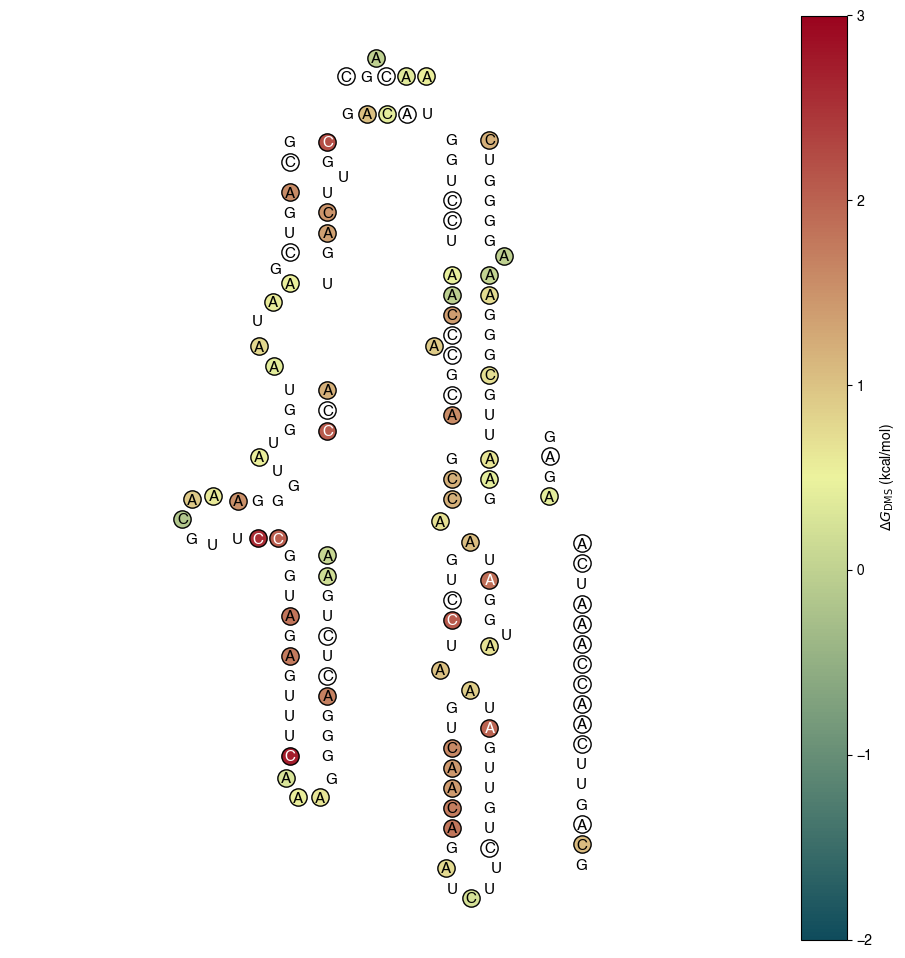

In [10]:
plot_structure_data_p4p6(p4p6_w_coords, 'dG0', (-2, 3),'p4p6_nomg.svg')

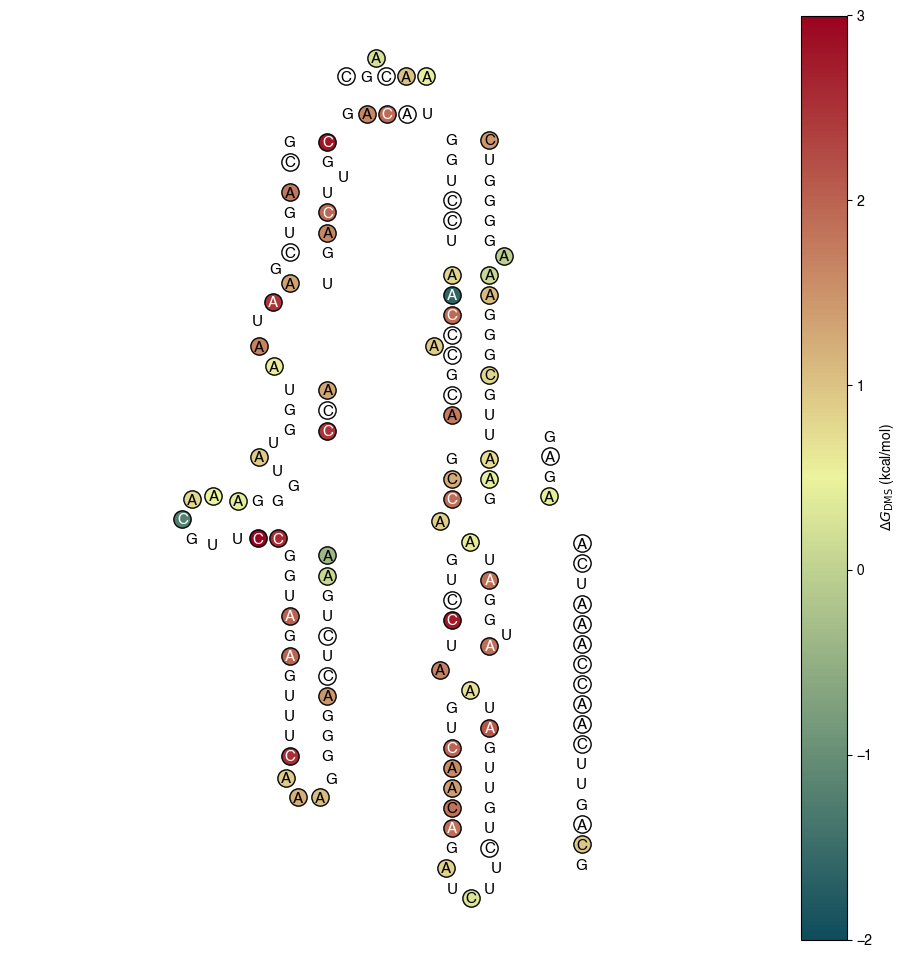

In [11]:
plot_structure_data_p4p6(p4p6_w_coords, 'dGMg', (-2, 3), 'p4p6_mg.svg')

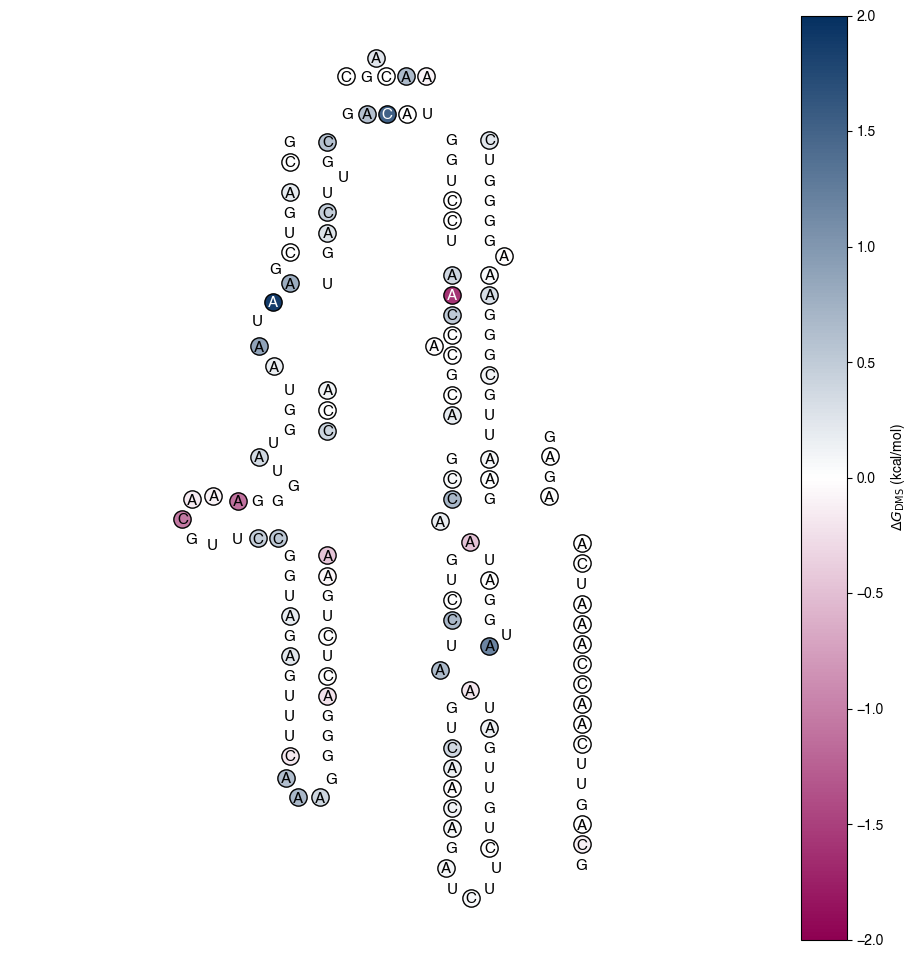

In [12]:
plot_structure_data_p4p6(p4p6_w_coords, 'ddG', (-2, 2),'p4p6_ddg.svg', cmap='PiBu')